### Systematic performance comparisons

Compare the following for recalibrating T5 cursor decoders:
- mean recalibration
- subspace realignment (optimized settings from `optimize_SubspaceRealignment.ipynb`)
- HMM (optimized settings from `optimize_vanillaHMM.ipynb`)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from copy import deepcopy
import glob, re
import sys, os

[sys.path.append(f) for f in glob.glob('../utils/*')]
import preprocess, sweep_utils
from plotting_utils import figSize
from lineplots import plotsd
from session_utils import *
from recalibration_utils import *
from click_utils import *

import sweep_utils
import resample

fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'


    
METHODS_DICT = dict() 
METHODS_DICT["HMM"] = {
        "hyperparameter_names" : ['kappa', 'inflection', 'exp'],
        "hyperparameter_optima" : [2, 70, 0.5],
    }

METHODS_DICT["Stabilizer"] = {
    "hyperparameter_names" : ['model', 'n_components', 'B', 'thresh'],
    "hyperparameter_optima" : ['FactorAnalysis', 6, 160, 0.01],
}

METHODS_DICT["ADAN"] = {
    "hyperparameter_names" : ['batch_size', 'g_lr', 'd_lr'],
    "hyperparameter_optima" : [16, 5e-6, 5e-6],
}
METHODS_DICT["HMM-Stabilizer"] = {
    "hyperparameter_names" : ['kappa', 'inflection', 'exp'],
}

In [6]:
# run for training set 
DATA_DIR = '/oak/stanford/groups/henderj/ghwilson/nonstationarities/T5/'
methods  = ['HMM', 'Stabilizer', 'HMM-Stabilizer', 'ADAN']
params   = [['kappa', 'inflection', 'exp'], 
            ['model', 'n_components', 'B', 'thresh'],
            ['kappa', 'inflection', 'exp'],
            ['batch_size', 'g_lr', 'd_lr']]


scores = list()
fields = ['R2_score', 'pearson_r', 'days_apart', 'file', 'meanrecal_R2_score', 'meanrecal_pearson_r',
         'suprecal_R2_score', 'suprecal_pearson_r', 'norecal_R2_score', 'norecal_pearson_r',]

for m, p in zip(methods, params):
    print('Loading test data.... \n')
    files = glob.glob(os.path.join(DATA_DIR, m, 'test/*'))
        
    if m == 'HMM':
        prune = dict(zip(p, [2, 70, 0.5]))
    elif m == 'Stabilizer':
        prune = dict(zip(p, ['FactorAnalysis', 6, 160, 0.01]))
    elif m == 'HMM-Stabilizer':
        prune = None
    elif m == 'ADAN':
        prune = dict(zip(p, [16, 5e-6, 5e-6]))
    else:
        raise ValueError('Method not recognized')
        
    scores_df = sweep_utils.getSummaryDataFrame(files, p + fields, prune = prune)
    scores_df = scores_df.sort_values(by = 'file', axis = 0).reset_index()
    scores.append(scores_df)
    print(m, ' results loaded.')
        
    
assert np.all([scores[i]['file'].equals(scores[i+1]['file']) for i in range(len(scores) - 1)]), "Order mismatch"

Loading test data.... 

HMM  results loaded.
Loading test data.... 

Stabilizer  results loaded.
Loading test data.... 

HMM-Stabilizer  results loaded.
Loading test data.... 

ADAN  results loaded.


In [7]:
paired_scores = dict()
for key in ['file', 'days_apart', 'meanrecal_pearson_r', 'meanrecal_R2_score', 'norecal_pearson_r', 'norecal_R2_score', 'suprecal_pearson_r', 'suprecal_R2_score']:
    paired_scores[key] = scores[0][key]

# get scores for each approach
for method, score in zip(methods, scores):
    paired_scores[method + '_pearson_r'] = score['pearson_r']
    paired_scores[method + '_R2_score'] = score['R2_score']
    
# get score differences:
for method1, score1 in zip(methods, scores): 
    for method2, score2 in zip(methods, scores): 
        if method1 != method2:
            paired_scores[method1 + '_vs_' + method2] = score1['pearson_r'] - score2['pearson_r']

paired_scores = pd.DataFrame(paired_scores)

In [32]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

def makeBarPlot(df: pd.DataFrame, metric: str, lims: tuple[float, float], alpha: float = None, save_fname: str = None):
    """Make a plot of the various approaches."""
    fields = ['meanrecal', 'Stabilizer', 'ADAN', 'HMM', 'HMM-Stabilizer']
    colors = ['k', 'orange', 'r', 'blue', 'purple']

    # Build a long-form DataFrame of (Method, Fraction)
    frac_df = pd.DataFrame({
        field: np.maximum(df[f"{field}_{metric}"] / df[f"suprecal_{metric}"], 0)
        for field in fields
    })
    frac_long = frac_df.melt(var_name='Method', value_name='Fraction')

    # Print medians & IQRs
    stats = frac_long.groupby('Method')['Fraction'].agg(
        median='median',
        q25=lambda x: np.percentile(x, 25),
        q75=lambda x: np.percentile(x, 75)
    )
    print(stats)

    # Pairwise Wilcoxon tests
    for i, f1 in enumerate(fields):
        for f2 in fields[:i]:
            p = scipy.stats.wilcoxon(frac_df[f1], frac_df[f2]).pvalue
            print(f"{f1} vs {f2}: p={p:.3g}")

    # Plot
    sns.stripplot(x='Method', y='Fraction', data=frac_long, alpha=0.8, palette=colors)
    sns.boxplot(x='Method', y='Fraction', data=frac_long, palette=colors)

    plt.ylim(lims)
    plt.ylabel(f'{metric}/{metric}_supervised')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if alpha is not None:
        modifyBoxPlotAlpha(ax, alpha)

    plt.tight_layout()
    if save_fname:
        print('Saving to:', save_fname)
        plt.savefig(save_fname, format='pdf')
    

239 replicates tested:
                  median       q25       q75
Method                                      
ADAN            0.892418  0.793828  0.980570
HMM             0.907067  0.852022  0.958418
HMM-Stabilizer  0.962488  0.927407  0.994964
Stabilizer      0.912770  0.834955  0.962427
meanrecal       0.776044  0.704343  0.874655
Stabilizer vs meanrecal: p=3.56e-19
ADAN vs meanrecal: p=9.87e-10
ADAN vs Stabilizer: p=0.0767
HMM vs meanrecal: p=2.72e-33
HMM vs Stabilizer: p=0.0688
HMM vs ADAN: p=0.0015
HMM-Stabilizer vs meanrecal: p=1.9e-37
HMM-Stabilizer vs Stabilizer: p=1.44e-33
HMM-Stabilizer vs ADAN: p=2.29e-19
HMM-Stabilizer vs HMM: p=6.53e-24
Saving to: /home/users/ghwilson/projects/nonstationarities/figures//comparisons/Fig4_pearson_r_plots


/tmp/ipykernel_14886/3982361393.py:35: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='Method', y='Fraction', data=frac_long, alpha=0.8, palette=colors)


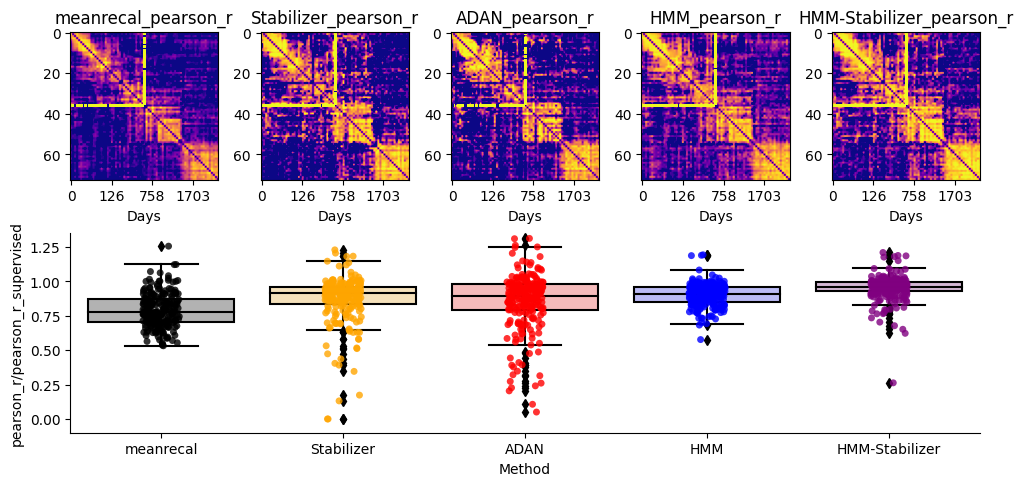

In [33]:
metric = 'pearson_r'
fields = ['meanrecal', 'Stabilizer', 'ADAN', 'HMM', 'HMM-Stabilizer']
normalize_heatmap = True

heatmap_lims = [0, 1]
scatter_lims = [-0.1, 1.35]
alpha        = 0.3
save_fname = fig_path + f'/comparisons/Fig4_{metric}_plots'
pearson_r_thresh = 0.15**0.5


fields = [x + f'_{metric}' for x in fields]
dates  = np.unique(np.concatenate([re.findall(r'(\d+.\d+.\d+)', x) for x in paired_scores['file']]))
days   = np.asarray([daysBetween(dates[0], x) for x in dates])

performance_mats = np.zeros((len(dates), len(dates), len(fields)))
time_mat = np.zeros((len(dates), len(dates)))
for idx, file in enumerate(paired_scores['file']):
    file_dates = re.findall(r'(\d+.\d+.\d+)', file)

    i = np.where(dates == file_dates[0])[0][0]
    j = np.where(dates == file_dates[1])[0][0]
    
        
    performance_mats[i, j, :] = paired_scores.iloc[idx][fields]
    performance_mats[j, i, :] = performance_mats[i, j, :]
    
    if normalize_heatmap:
        performance_mats[i, j, :] /= paired_scores.iloc[idx]['suprecal_' + metric]
        performance_mats[j, i, :] /= paired_scores.iloc[idx]['suprecal_' + metric]
    
        
    time_mat[i, j] = preprocess.daysBetween(*file_dates)
    time_mat[j, i] = preprocess.daysBetween(*file_dates)
    
    
from plotting_utils import modifyBoxPlotAlpha
from mpl_toolkits.axes_grid1 import make_axes_locatable


for i in range(len(fields)):
    plt.subplot(2,5,i + 1)
    im = plt.imshow(performance_mats[:, :, i], cmap='plasma')
    plt.clim(heatmap_lims)
    plt.xlabel('Days')
    ax = plt.gca()
    ax.set_xticks([0, 20, 40, 60], days[[0, 20, 40, 60]])
    plt.title(fields[i])
    
    
plt.tight_layout()

plt.subplot(2, 1, 2)
figSize(5, 10)
scores_subset = paired_scores[paired_scores['meanrecal_pearson_r'] > pearson_r_thresh]
print(f"{len(scores_subset)} replicates tested:")
makeBarPlot(scores_subset, metric = metric, lims = scatter_lims, alpha = alpha, save_fname = save_fname)

plt.show()

#create color bar
# plt.figure(figsize=(0.1, 3))
# plt.colorbar(im, cax = plt.gca(), orientation="vertical")
# plt.savefig(save_fname + '_cmap', format = 'pdf')

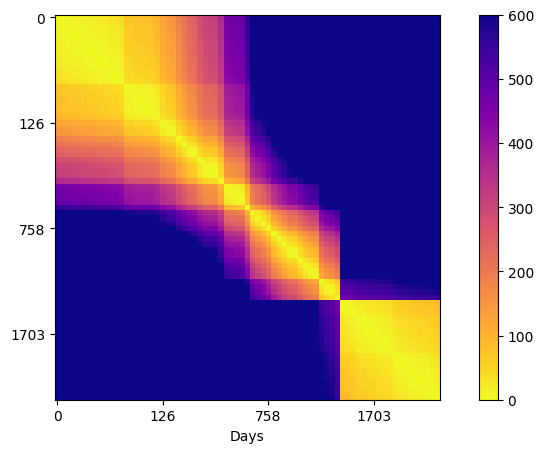

In [34]:
im = plt.imshow(time_mat, cmap='plasma_r')
plt.clim([0, 600])
plt.colorbar()
plt.xlabel('Days')
ax = plt.gca()
ax.set_xticks([0, 20, 40, 60], days[[0, 20, 40, 60]])
ax.set_yticks([0, 20, 40, 60], days[[0, 20, 40, 60]])

#plt.savefig(save_fname + '_timeapart_heatmap', format = 'pdf')

First look at data where decoders are kinda working:

In [7]:
def makePairedScoresPlot(df, pairs, metric, lims, cmap = 'autumn', save_fname = None):

    for i, pair in enumerate(pairs):
        plt.subplot(3, 3, i + 1)
        plt.plot(lims, lims, color = 'k')
        
        df_clipped = df[df.suprecal_R2_score > -1e10]
        
        x_vals = df_clipped[pair[0] + '_' + metric]
        y_vals = df_clipped[pair[1] + '_' + metric]
        
        plt.scatter(x_vals, y_vals, c = np.log10(df_clipped['days_apart']), cmap = cmap)
        plt.xlim(lims)
        plt.ylim(lims)
        plt.xticks(lims)
        plt.yticks(lims)
        
        plt.xlabel(pair[0] + f' {metric}')
        plt.ylabel(pair[1] + f' {metric}')
        
        plt.text(lims[0] + 0.02, lims[1] - 0.04, 'Instances better: {}/{}'.format(sum(y_vals > x_vals), len(x_vals)), fontsize = 8)
        plt.text(lims[0] + 0.02, lims[1] - 0.01, 'Median improvement (%): {:.2f}'.format(100 * np.median((y_vals - x_vals) / x_vals)), fontsize = 8)
        plt.text(lims[0] + 0.02, lims[1] - 0.07, 'p = {:.2f}'.format(scipy.stats.wilcoxon(y_vals, x_vals)[1]), fontsize = 8)

        
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    if save_fname is not None:
        print('Saving to:', save_fname)
        plt.savefig(save_fname, format = 'pdf')
    plt.tight_layout()
    plt.show()
    

Pearson r
Saving to: /home/users/ghwilson/projects/nonstationarities/figures/comparisons/scatters_pearson_r


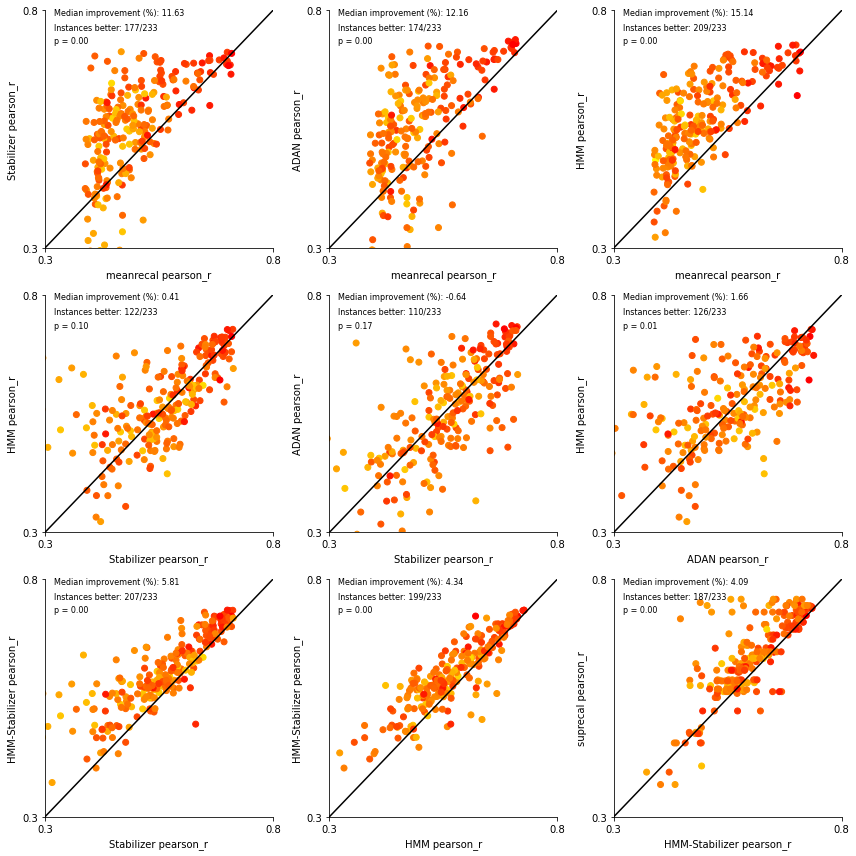

R2 score
Saving to: /home/users/ghwilson/projects/nonstationarities/figures/comparisons/scatters_R2_score


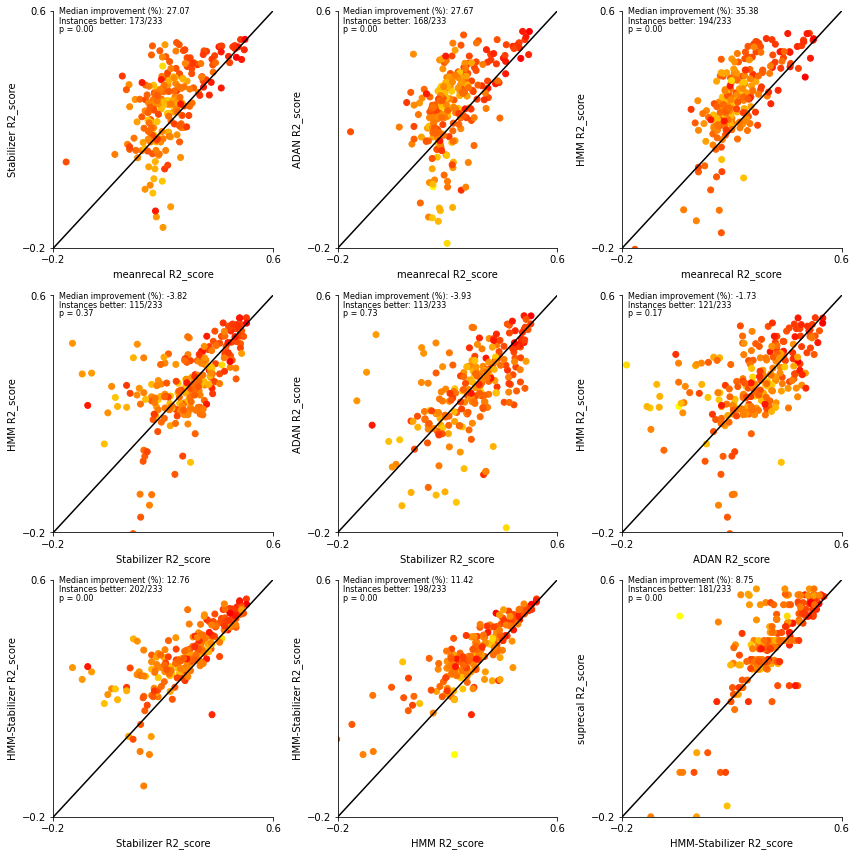

In [8]:
metric      = 'pearson_r'
lims        = [0.3, 0.8]
cmap        = 'autumn'
save_fname  = os.path.join(fig_path, f'comparisons/scatters_{metric}')
pearson_r_thresh = 0.15**0.5


# Base models
pairs = [['meanrecal', 'Stabilizer'], ['meanrecal', 'ADAN'], ['meanrecal', 'HMM'],
         ['Stabilizer', 'HMM'], ['Stabilizer', 'ADAN'], ['ADAN', 'HMM'], 
        ['Stabilizer', 'HMM-Stabilizer'], ['HMM', 'HMM-Stabilizer'], ['HMM-Stabilizer', 'suprecal']]

scores_subset = paired_scores[paired_scores['meanrecal_pearson_r'] > pearson_r_thresh]

# pearson r:
figSize(12, 12)
print('Pearson r')
makePairedScoresPlot(scores_subset, pairs, metric = metric, lims = lims, cmap = cmap, save_fname = save_fname)

# R2 score:
metric     = 'R2_score'
lims       = [-0.2, 0.6]
save_fname = os.path.join(fig_path, f'comparisons/scatters_{metric}')

figSize(12, 12)
print('R2 score')
makePairedScoresPlot(scores_subset, pairs, metric = metric, lims = lims, cmap = cmap, save_fname = save_fname)

In [300]:
# TODO: NOT AN ISSUE HERE BUT IN GENERAL YOU NEED TO NORMALIZE MEDIAN IMPROVMENET BY ABS(REF), NOT REF
# e.g. (A - B) / np.abs(B) 

metric = 'pearson_r'
pearson_r_thresh = 0.15**0.5
remove_outliers  = True

fields        = [x + metric for x in ['norecal_', 'meanrecal_', 'Stabilizer_', 'HMM_', 'ADAN_', 'HMM-Stabilizer_', 'suprecal_']]
scores_subset = paired_scores[paired_scores['meanrecal_pearson_r'] > pearson_r_thresh]

if remove_outliers:
    scores_subset = scores_subset[scores_subset.suprecal_R2_score > -1e10]

for i, field1 in enumerate(fields):
    print('---------------', field1, '----------------')
    for j, field2 in enumerate(fields):
        if j > i:
            print(field1, 'vs', field2, ':')
            mean = np.mean(scores_subset[field1] - scores_subset[field2])
            std  = np.std(scores_subset[field1] - scores_subset[field2])
            print('Difference (mean +- SD): ', np.round(mean, 3),
                 '+-', np.round(std, 3)) 
            print('Number of instances worse than', field2, ':', sum((scores_subset[field1] - scores_subset[field2]) < 0),
                  '/', len(scores_subset[field1]))
            print('\n')

--------------- norecal_pearson_r ----------------
norecal_pearson_r vs meanrecal_pearson_r :
Difference (mean +- SD):  -0.022 +- 0.036
Number of instances worse than meanrecal_pearson_r : 170 / 233


norecal_pearson_r vs Stabilizer_pearson_r :
Difference (mean +- SD):  -0.076 +- 0.103
Number of instances worse than Stabilizer_pearson_r : 190 / 233


norecal_pearson_r vs HMM_pearson_r :
Difference (mean +- SD):  -0.098 +- 0.076
Number of instances worse than HMM_pearson_r : 213 / 233


norecal_pearson_r vs ADAN_pearson_r :
Difference (mean +- SD):  -0.063 +- 0.112
Number of instances worse than ADAN_pearson_r : 179 / 233


norecal_pearson_r vs HMM-Stabilizer_pearson_r :
Difference (mean +- SD):  -0.127 +- 0.074
Number of instances worse than HMM-Stabilizer_pearson_r : 227 / 233


norecal_pearson_r vs suprecal_pearson_r :
Difference (mean +- SD):  -0.161 +- 0.096
Number of instances worse than suprecal_pearson_r : 221 / 233


--------------- meanrecal_pearson_r ----------------
meanreca

## Angular drift analysis 

Now let's analyze case where tuning has shifted significantly, meaning mean recalibration fails. First we'll generate cosine tuning coefficients for each session, then plot various methods' performance against the angular drift estimate.

In [35]:
from CosineTuning import fitEncodingMatrix, getAngles
from sklearn.linear_model import Lasso

min_nblocks = 2
FILE_DIR    = '/oak/stanford/groups/henderj/ghwilson/nonstationarities/T5/'


filelist    = glob.glob(FILE_DIR + 'historical/*')
filelist.extend(glob.glob(FILE_DIR + 'new/*'))

block_constraints = getBlockConstraints(FILE_DIR)
filelist          = get_Sessions(filelist, min_nblocks,  block_constraints = block_constraints)

In [36]:
import os, pickle

decoder_folder = '/oak/stanford/groups/henderj/ghwilson/nonstationarities/T5/session_decoders/'

encoders_dict = dict()
for i, file in enumerate(filelist):
    
    date  = file.split('t5.')[-1].split('.mat')[0]
    file  = glob.glob(os.path.join(decoder_folder, date + '*'))[0]
    model = pickle.load(open(file, 'rb'))['decoder']
    
    encoders_dict[date] = model.coef_
    
    if (i+1) % 10 == 0:
        print(f'{i+1}/{len(filelist)}')

/home/users/ghwilson/.local/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Ridge from version 1.0.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


10/73
20/73
30/73
40/73
50/73
60/73
70/73


In [37]:
from CosineTuning import estimateSubspaceDrift

def helper_func(row):
    for key in drift_dict.keys():
        if key in row['file']:
            return drift_dict[key]
        
# first get all pairwise angular drift measurements
drift_dict = dict()
for ref_date, ref_encoder in encoders_dict.items():
    for new_date, new_encoder in encoders_dict.items():
        key = f'{ref_date}_to_{new_date}'
        if key not in encoders_dict.keys() and new_date > ref_date: 
            drift_dict[key] = estimateSubspaceDrift(ref_encoder, new_encoder)
        
# then assign to corresponding fields in paired_scores
paired_scores['X_drift'] = paired_scores.apply (lambda row: helper_func(row)[0], axis=1)
paired_scores['Y_drift'] = paired_scores.apply (lambda row: helper_func(row)[1], axis=1)

In [38]:
import numpy as np
from scipy.interpolate import interp1d

def fill_nans_scipy1(padata, pkind='linear'):
    """
    Interpolates data to fill nan values

    Parameters:
        padata : nd array 
            source data with np.NaN values

    Returns:
        nd array 
            resulting data with interpolated values instead of nans
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)



def irregularGridRollingAverage(x, y, winsize, winstep, sigma = None):

    x_fit = list()
    y_fit = list()
    
    i = x.min()
    while i < x.max():
        win_idxs = np.logical_and(x >= i - winsize/2, x <= i + winsize/2)
        y_window = y[win_idxs]
        
        if sigma is not None: # use gaussian weighting
            weights  = np.exp(-1 * (x[win_idxs] - i)**2 / (2 * sigma**2) )
        else:  # use identical weighting --> standard average
            weights = np.ones(y_window.shape)
        
        avg = y_window.dot(weights) / sum(weights)
        
        y_fit.append(avg)
        x_fit.append(i)
        i += winstep

    x_fit = np.asarray(x_fit)
    y_fit = np.asarray(y_fit)
    
    y_fit = fill_nans_scipy1(y_fit)
    
    return x_fit, y_fit

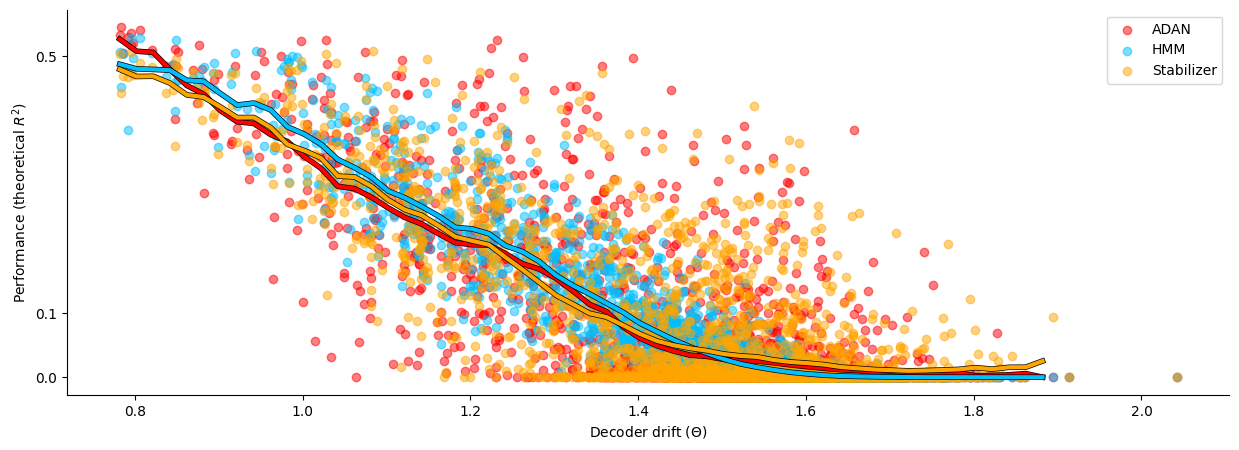

In [39]:
import scipy.interpolate
import matplotlib.patheffects as pe
figSize(5, 15)

save_fname        = os.path.join(fig_path, 'comparisons/performance_with_decoder_angle')
suprecal_r_thresh = 0.15**0.5

winsize = 0.1
winstep = 0.02
sigma   = 0.5
#-----------------------------

colors = ['orange', 'deepskyblue', 'red'][::-1]
fields = ['Stabilizer_pearson_r', 'HMM_pearson_r', 'ADAN_pearson_r'][::-1]

scores_subset = paired_scores[paired_scores['suprecal_pearson_r'] > suprecal_r_thresh]

for key, color in zip(fields, colors):
    diff  = np.maximum(scores_subset[key].to_numpy(), 0)**2
    angle = np.arccos(np.asarray(scores_subset['meanrecal_pearson_r']))
    plt.scatter(angle, diff, alpha = 0.5, c = color, label = key.split('_pearson')[0])
    
    reorder_idx = np.argsort(angle)
    angle      = angle[reorder_idx]
    diff       = diff[reorder_idx]
    
    angle_mesh, pred = irregularGridRollingAverage(angle[angle < 1.9], diff[angle <1.9], winsize, winstep, sigma)
    plt.plot(angle_mesh, pred, c = color, linewidth = 3, path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
     
    
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, 0.1, 0.5])

plt.xlabel('Decoder drift ($\Theta$)')
plt.ylabel('Performance (theoretical $R^2$)')
plt.savefig(save_fname, format = 'pdf')
plt.legend()